## General Overview

The main goal of this research is to prepare and compare a few models to predict borrower's default rate. The data is sourced from Kaggle website: https://www.kaggle.com/wendykan/lending-club-loan-data/downloads/lending-club-loan-data.zip. It contains complete loan data for all loans issued through the 2007-2015, what makes about 890 thousand observations in total. There are 3 separate files inside the zipped file:

- loan.csv -> entire data in CSV format
- database.sqlite -> entire data in SQL format
- LCDataDictionary.xlsx -> dictionary with variables description

For the purpose of this study, I am going to use .csv file as the most convenient and natural for Pandas environment. 

Let's start off by importing the necessary modules and reading the file.

In [1]:
# Basic modules for dataframe manipulation
import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

# Data Standardization
from sklearn.preprocessing import StandardScaler

# Cross Validaton
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Don't display warnings 
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read the file into dataframe
df_raw = pd.read_csv('loan.csv', low_memory=False)
print("Number of records: {}\nNumber of variables: {}".format(df_raw.shape[0], df_raw.shape[1]))

Number of records: 887379
Number of variables: 74


It is important to look at the data in order to understand its format, structure, value types, missing values notation, etc. 

In [3]:
# Display first 5 lines
df_raw.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The first lines show us a bunch of columns representing a wide range of different types of things such as id, term, or grade. This means, that we deal with **structured data**. 

In [4]:
# Check the type and number of non-null values of each column
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
id                             887379 non-null int64
member_id                      887379 non-null int64
loan_amnt                      887379 non-null float64
funded_amnt                    887379 non-null float64
funded_amnt_inv                887379 non-null float64
term                           887379 non-null object
int_rate                       887379 non-null float64
installment                    887379 non-null float64
grade                          887379 non-null object
sub_grade                      887379 non-null object
emp_title                      835922 non-null object
emp_length                     887379 non-null object
home_ownership                 887379 non-null object
annual_inc                     887375 non-null float64
verification_status            887379 non-null object
issue_d                        887379 non-null object
loan_status          

This dataset contains a mix of continuous and categorical variables. The latter are currently stored as 'objects', which is an unefficient way of storing string data, so it is necessary to convert them into 'category'. 

## Data pre-processing

Data pre-processing is a critical step that needs to be taken to convert the raw data into a clean data set. The common steps are:

- **Cleaning**: removal or fixing missing data
- **Formatting**: adjusting the type of each column and making them suitable for machine learning algorithms
- **Sampling**: selecting a small, representative sample, what results in computational time reduction

I will execute all of the listed steps. 

### Cleaning

In the above window, we observe that the 'NANs' fraction is really heavy in over a dozen of columns. I will discard all features consisting of 75%+ missing values, in order to avoid assumptions on such a large scale. For remaining columns, I will apply the following imputation methods: median for continuous variables and mode for categorical ones. Median is usually more preferable to mean, because of negligible impact of outliers.

In [5]:
# Select and print missing values ratio in descending order
nans = df_raw.isnull().sum().sort_values(ascending=False)/len(df_raw)
print(nans)

dti_joint                      0.999426
verification_status_joint      0.999424
annual_inc_joint               0.999424
il_util                        0.979020
mths_since_rcnt_il             0.976549
all_util                       0.975916
max_bal_bc                     0.975916
open_rv_24m                    0.975916
open_rv_12m                    0.975916
total_cu_tl                    0.975916
total_bal_il                   0.975916
open_il_24m                    0.975916
open_il_12m                    0.975916
open_il_6m                     0.975916
open_acc_6m                    0.975916
inq_fi                         0.975916
inq_last_12m                   0.975916
desc                           0.857976
mths_since_last_record         0.845553
mths_since_last_major_derog    0.750160
mths_since_last_delinq         0.511971
next_pymnt_d                   0.285077
tot_cur_bal                    0.079195
total_rev_hi_lim               0.079195
tot_coll_amt                   0.079195


In [6]:
# Copy all columns containing less then 75% of missing values to new variable: 'df'
df = df_raw.loc[:, nans < 0.75]

It is a good moment to specify our **target** variable. Default client is defined as one with *loan_status* variable taking on the following levels:

- Charged off
- Default
- Does not meet the credit policy. Status: Charged Off
- Late (31-120 days)

Having this piece of information we can make an assumption that all remaining levels represent customers not being set as default.
First of all, I will check for unique values in *loan_status* to avoid misspellings in passing them into a new variable: *default*. Then, I will assign all remaining distinct values into the variable: *not_default*, using list comprehension - an effective "Pythonic" construction. To conclude this step, I will denote all default clients as 1, and others as 0.

In [7]:
# Show distinct values of 'loan status'
df['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off', 'Issued'],
      dtype=object)

In [8]:
# Assign column names to corresponding variables
default = ['Charged Off', 'Default', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off']
not_default = [x for x in df['loan_status'].unique() if x not in default]

In [9]:
# Convert to numbers
df['loan_status'].replace(default, 1, inplace=True)
df['loan_status'].replace(not_default, 0, inplace=True)


Let's find out how our dependent variable is distributed:

0    828560
1     58819
Name: loan_status, dtype: int64
Total friction of default clients = 7.10%


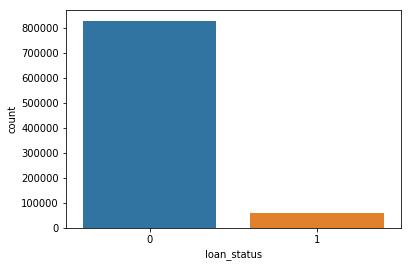

In [10]:
# Count values
distr = df['loan_status'].value_counts()
print(distr)
print("Total friction of default clients = {0:.2f}%".format((distr[1]/distr[0])*100))

# Plot the distribution
sns.countplot('loan_status', data=df)
plt.show()

Since the distribution of our endogenous variable is very unbalanced, standard "accuracy" would not be sufficient to properly asses how a particular model performs. I will come back to this topic a bit later. 

### Formatting

In this section, I am going to convert *object* types into *category*, fix missing values and take a closer look at all variables. 
I will iterate through a certain type of columns using *for loops* to perform necessary operations on them. These actions will result in a clean data frame, prepared for machine learning modelling. 

In [11]:
# Change any columns of strings in a panda's dataframe to a column of catagorical values. Create a list of this sort of columns.
categorical = []
for n, c in df.items():
    if is_string_dtype(c):
        df[n] = c.astype('category').cat.as_ordered()
        categorical.append(n)

In [12]:
# Iterate through all columns, select numeric columns (float, integer) containing missing values, and fill NANs with median
for n, c in df.items(): 
    if is_numeric_dtype(c):
        if pd.isnull(c).sum() > 0:
            df.loc[:,n] = c.fillna(c.median())

In [13]:
# Fill NANs in categorical variables with mode
for n, c in df.items():
    if is_categorical_dtype(c):
        if pd.isnull(c).sum() > 0:
            df[n] = c.fillna(c.mode()[0])

In [14]:
# Show the result of formatting
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 54 columns):
id                            887379 non-null int64
member_id                     887379 non-null int64
loan_amnt                     887379 non-null float64
funded_amnt                   887379 non-null float64
funded_amnt_inv               887379 non-null float64
term                          887379 non-null category
int_rate                      887379 non-null float64
installment                   887379 non-null float64
grade                         887379 non-null category
sub_grade                     887379 non-null category
emp_title                     887379 non-null category
emp_length                    887379 non-null category
home_ownership                887379 non-null category
annual_inc                    887379 non-null float64
verification_status           887379 non-null category
issue_d                       887379 non-null category
loan_status          

The data frame looks much better now!

There are two types of categorical variables: nominal and ordinal. It is beneficial for predictive models performance to identify the ordinal ones and "tell them" what the correct hierarchy is unless already ordered correctly.

In [15]:
# Display 7 randomly selected rows
df[categorical].sample(7)

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,pymnt_plan,url,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type
244683,36 months,B,B4,Owner,10+ years,RENT,Not Verified,Dec-2014,n,https://www.lendingclub.com/browse/loanDetail....,debt_consolidation,Debt consolidation,100xx,NY,Jun-1990,f,Jan-2016,Feb-2016,Jan-2016,INDIVIDUAL
552599,36 months,C,C4,District Manager,10+ years,MORTGAGE,Verified,Oct-2015,n,https://www.lendingclub.com/browse/loanDetail....,debt_consolidation,Debt consolidation,871xx,NM,Aug-2005,f,Dec-2015,Feb-2016,Jan-2016,INDIVIDUAL
86183,36 months,C,C5,Community memorial health systems,6 years,RENT,Verified,Sep-2013,n,https://www.lendingclub.com/browse/loanDetail....,debt_consolidation,Life's a Journey,934xx,CA,Dec-1993,w,Mar-2014,Feb-2016,Oct-2015,INDIVIDUAL
836102,36 months,A,A5,Pharmacy Technician,8 years,RENT,Verified,Feb-2015,n,https://www.lendingclub.com/browse/loanDetail....,other,Other,940xx,CA,Jun-2003,f,Jan-2016,Feb-2016,Jan-2016,INDIVIDUAL
258626,36 months,B,B2,Firefighter Paramedic,1 year,MORTGAGE,Source Verified,Nov-2014,n,https://www.lendingclub.com/browse/loanDetail....,debt_consolidation,Debt consolidation,226xx,VA,Feb-1998,f,Dec-2014,Feb-2016,Dec-2014,INDIVIDUAL
491134,36 months,B,B1,SECURITY OFFICER,3 years,MORTGAGE,Not Verified,Dec-2015,n,https://www.lendingclub.com/browse/loanDetail....,credit_card,Credit card refinancing,294xx,SC,Sep-1992,w,Jan-2016,Feb-2016,Jan-2016,INDIVIDUAL
568847,36 months,A,A5,Server,1 year,RENT,Verified,Oct-2015,n,https://www.lendingclub.com/browse/loanDetail....,debt_consolidation,Debt consolidation,606xx,IL,Apr-2005,w,Jan-2016,Feb-2016,Jan-2016,INDIVIDUAL


In [16]:
# Show categories in relevant columns
for c in df[categorical]:
    print("{}: {}".format(c, df[c].cat.categories))

term: Index([' 36 months', ' 60 months'], dtype='object')
grade: Index(['A', 'B', 'C', 'D', 'E', 'F', 'G'], dtype='object')
sub_grade: Index(['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2',
       'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4',
       'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5'],
      dtype='object')
emp_title: Index([' \tAdv Mtr Proj Fld Rep', '       NSA Industries llc',
       '    MOTHER  THERESA  HOME', '    Quitman Street Community School',
       '   Bus Operator and Instructor', '   Fibro Source',
       '   Long Ilsand College Hospital', '   day care proivder',
       '   letter carrier    ', '   mortgage banker',
       ...
       'zoning compliance officer', 'zoning inspector', 'zookeeper',
       'zoom de italy', 'zozaya officiating', 'zs backroom',
       'zueck transportation', 'zulily', 'År.  Technical Illustrator',
       '​License Compliance Investigator'],
      dtype='object', len

We observe, that first columns *term* and *grade* are ordered correctly, yet the column *emp_length* has to be reordered. Other features are nominal, hence no action is required. There are some dates that could possibly be transformed into "data" type, but this will not improve our model performance. Such conversion would be vital while tackling a time-series problem. The column *url* is also unnecessary here as it does not bring any useful information.

In [17]:
# Reorder 'emp_length' column
df.emp_length.cat.set_categories(['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years',
       '6 years', '7 years', '8 years', '9 years', '10+ years', 'n/a'], ordered=True, inplace=True)

In [18]:
# Delete 'url' column
df.drop(['url'], axis=1, inplace=True)

Below loop will help to collect all numerical variables as a list, so we can take a look at their basic statistics.

In [19]:
# Make a list of numerical columns
numerical = []
for n, c in df.items():
    if is_numeric_dtype(c):
        numerical.append(n)

In [20]:
# Display basic statistics
df[numerical].describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,loan_status,dti,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
count,8.873790e+05,8.873790e+05,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,8.873790e+05,887379.000000,887379.000000,...,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.0,887379.000000,8.873790e+05,8.873790e+05,8.873790e+05
mean,3.246513e+07,3.500182e+07,14755.264605,14741.877625,14702.464383,13.246740,436.717127,7.502754e+04,0.066284,18.157039,...,0.396692,45.919243,4.880757,2164.145585,0.014377,1.0,0.004991,2.078281e+02,1.347937e+05,3.140587e+04
std,2.282734e+07,2.411335e+07,8435.455601,8429.897657,8442.106732,4.381867,244.186593,6.469816e+04,0.248778,17.190626,...,4.087825,409.693874,63.125281,4794.783233,0.134180,0.0,0.077624,9.894829e+03,1.483912e+05,3.605369e+04
min,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.320000,15.670000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.206643e+06,1.087713e+07,8000.000000,8000.000000,8000.000000,9.990000,260.705000,4.500000e+04,0.000000,11.910000,...,0.000000,0.000000,0.000000,280.170000,0.000000,1.0,0.000000,0.000000e+00,3.224600e+04,1.470000e+04
50%,3.443327e+07,3.709528e+07,13000.000000,13000.000000,13000.000000,12.990000,382.550000,6.500000e+04,0.000000,17.650000,...,0.000000,0.000000,0.000000,462.780000,0.000000,1.0,0.000000,0.000000e+00,8.055900e+04,2.370000e+04
75%,5.490814e+07,5.847135e+07,20000.000000,20000.000000,20000.000000,16.200000,572.600000,9.000000e+04,0.000000,23.950000,...,0.000000,0.000000,0.000000,831.245000,0.000000,1.0,0.000000,0.000000e+00,1.957940e+05,3.780000e+04
max,6.861706e+07,7.354484e+07,35000.000000,35000.000000,35000.000000,28.990000,1445.460000,9.500000e+06,1.000000,9999.000000,...,358.680000,33520.270000,7002.190000,36475.590000,20.000000,1.0,14.000000,9.152545e+06,8.000078e+06,9.999999e+06


Two things bring my attention here: 

- both *id* and *member_id* are just ordinal numbers that can be deleted without having any negative impact on our model and make it lighter
- max number in *dti* looks suspicious comparing to its mean and standard deviation; these outliers need be checked and possibly changed

In [21]:
# Delete 'id' and 'member_id' column
df.drop(['id', 'member_id'], axis=1, inplace=True)

In [22]:
# Find outliers in 'dti' column
df.dti[df.dti > 100]

475046    1092.52
476900     137.40
480179     136.97
484446    9999.00
489021     100.09
521751     120.66
531886    9999.00
532701     380.53
540456     672.52
544139     125.25
563635     104.00
Name: dti, dtype: float64

In [23]:
# Replace unrealistic figures with median
df.dti.iloc[[484446, 531886]] = df.dti.median()

Since most machine learning models require numbers only, the next step is to convert everything into numbers.

In [24]:
# Change a category to respective number
for n, c in df.items():
    if not is_numeric_dtype(c):
        df[n] = c.cat.codes

It is time for the final look into the pre-processed dataframe

In [25]:
# Show 5 first lines
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000.0,5000.0,4975.0,0,10.65,162.87,1,6,228736,10,...,171.62,33,41,0.0,1.0,0,0.0,0.0,80559.0,23700.0
1,2500.0,2500.0,2500.0,1,15.27,59.83,2,13,191489,0,...,119.66,33,100,0.0,1.0,0,0.0,0.0,80559.0,23700.0
2,2400.0,2400.0,2400.0,0,15.96,84.33,2,14,228736,10,...,649.91,33,41,0.0,1.0,0,0.0,0.0,80559.0,23700.0
3,10000.0,10000.0,10000.0,0,13.49,339.31,2,10,3274,10,...,357.48,33,40,0.0,1.0,0,0.0,0.0,80559.0,23700.0
4,3000.0,3000.0,3000.0,1,12.69,67.79,1,9,241927,1,...,67.79,33,41,0.0,1.0,0,0.0,0.0,80559.0,23700.0


The last step of pre-processing stage I mentioned earlier is **sampling**. Firstly, I will create a helper function for dataframe downsizing. This will significantly improve the computation time required for hyperparamater tuning process in complex algorithms like Random Forest or XGB. Next, I will split the data frame into Labels and Target and finish this section by splitting all data into train/test sets containing 70%/30% of all clients respectively. It is also good practice to perform a split so that the labels are distributed in train and test sets as they are in the original dataset. To achieve this we use the keyword argument: **stratify = y**.

In [26]:
# Get a sample of the dataframe
def sample(df, num):
    index = sorted(np.random.permutation(len(df))[:num])
    return df.iloc[index].copy()

In [27]:
# Drop the dependent variable from the original dataset
X = df.drop(['loan_status'], axis=1)

# Assign the dependent variable into a separate variable
y = df['loan_status']

In [28]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2606, stratify=y)

## Metrics

It is important to choose appropriate metric for a project. 

In classification, to measure model performance, *accuracy* is a commonly-used metric. It tells us what is a fraction of correctly classified samples. However, accuracy is not always the most effective metric. In our problem, 93.1% are *not-default clients* and only 6.9% are *default clients*. We can build a baseline model that classifies all clients as *not-default*. This model would be correct 93.1% of the time and thus have an accuracy of 93.1%. 

In that case, this naive classifier would do a horrible job of predicting *default customers*. It never makes such prediction, so it completely fails at its original purpose. The situation, when one class occurs more frequent is called class imbalance and requires a more nuanced metric to assess the performance of our models. 

Given a binary classification task, we can draw up a confusion matrix that summarizes predictive performance. It is 2x2 matrix providing us with following rates:

True Positive - the number of default customers correctly labelled

True Negative - the number of not-default customers correctly labelled

False Negative - the number of not-default customers incorrectly labelled

False Positive - the number of default customers incorrectly labelled

In case of Lending Club, high rate of False Negatives can be devastating, as the lent money is lost. This scenario is much more costly than a high rate of False Positives when merely potential earnings are restricted.

I will display also additional metrics to support our models evaluation:

High Precision - if we predict 'default customer', it's very likely a correct prediction 

High Recall (Sensitivity) - if a customer is 'default', we usually predict this fact correctly

The F1 score is a weighted average of *precision* and *recall*.

The ROC curve helps us choose the best probability threshold to achieve optimal True Positive / False Positive ratio. 
The larger area under ROC curve, the better our model is. This area is commonly denoted as AUC, and this is another metric for classification models. In this research, I consider **AUC** as the metric that determines the overall performance of a model, and thus I will do my best to achieve as high result as possible. On top of that, I will try to minimize False Negative rate.

Now, I will create a few helper functions to call them later for making a summary of each model.

In [29]:
  def print_score(a):
    
    # Compute and print accuracy for training and test set
    print("Training accuracy: {}, Test accuracy: {}".format(a.score(X_train, y_train), a.score(X_test, y_test)))
    
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = a.predict_proba(X_test)[:,1]

    # Compute and print AUC score
    print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

In [30]:
def report(a):
        
    # Compute predictions on test set
    y_pred = a.predict(X_test)
    
    # Print classification report
    print("Classification Report:\n{}".format(classification_report(y_test, y_pred)))
    
    # Print confusion matrix
    print("Confusion Matrix:\n{}".format(confusion_matrix(y_test, y_pred)))

In [31]:
def plot_ROC(a):

    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = a.predict_proba(X_test)[:,1]

    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

## Machine Learning

We are well prepared now for an endeavour to create a robust and accurate predictive model.

### Logistic Regression

It is a good practice to start with a simple model that solves the problem and think about it as a baseline. Logistic Regression is perceived as a go-to method for binary classification problems. Calculations run quickly and is easy to interpret.
It assumes Gaussian Distribution, hence *standardization* is essential for using this algorithm. Here, I introduce a useful *sklearn* module,  **pipeline**, which lets me apply standardization and run a model in just one line of code. 

In [32]:
# Instantiate a standardization function and classification method (Logistc Regression) and input them as arguments for the pipeline
LR_pipe = Pipeline([('standardize', StandardScaler()), ('classification', LogisticRegression())])
# Fit the model
%time LR_pipe.fit(X_train, y_train)
# Print accuracy metrics defined before in function: 'print_score'
print_score(LR_pipe)

Wall time: 1min 40s
Training accuracy: 0.9898271795738652, Test accuracy: 0.9895798117304124
AUC: 0.971372807756555


This is our first model and at the same a kind of benchmark for next ones. Very high accuracy and AUC suggest that all models will be competing for decimal numbers. 

In [33]:
# Display a classification report and a confusion matrix
report(LR_pipe)

Classification Report:
             precision    recall  f1-score   support

          0       0.99      1.00      0.99    248568
          1       0.97      0.87      0.92     17646

avg / total       0.99      0.99      0.99    266214

Confusion Matrix:
[[248166    402]
 [  2372  15274]]


Precision/recall/f1-score metrics almost reached the maximum edge, so they will not be very useful for performance assessment.

Conversely, from confusion matrix, we learn that our model 402 times (FP) falsely predicted that customer will default and 2372 times (FN) falsely predicted that a client will not default (expensive mistake!).

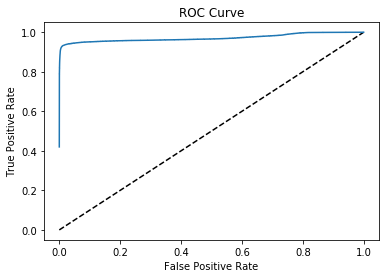

In [34]:
# Display ROC
plot_ROC(LR_pipe)

The accuracy is so high, that it is almost impossible to read off the optimal probability threshold for TP/FP ratio

### Random Forest

It is a sort of universal Machine Learning technique, a way of predicting something that could be of any kind - category (like this problem) or continues variable (like price). In general, it does not overfit too badly and it is not hard to stop it from overfitting. It has few (if any) statistical assumptions. It does not assume that given data is normally distributed, relationships are linear, or that interactions have been specified. It requires relatively few feature engineering, like for example taking 'log' of the data.

Random Forest algorithm is based on bagging trees. The idea of **bagging** is to create a couple of subsets of data and used to train the model. For example imagine as if we created five different models, each of which was only somewhat predictive, but the models were not correlated with each other. Five models would have a different insight into the relationships of the data. If we took average of them, we end up with the ensemble of different models. The number of said models can be set using *n_estimators* hyperparameter.

Comparing to Logistic Regression, Random Forest is not so easy to explain due to higher complexity. However, there are some tools making it possible. I will create now a helper function to retrieve the most important features that influence our model performance.

In [35]:
# Create a function for plotting feature importances
def plot_feat_imp(alg):
    indices = np.argsort(alg.feature_importances_)[::-1][:15]

    fig = plt.figure(figsize=(6, 9))
    p = sns.barplot(y=df.columns[indices][:15], x = alg.feature_importances_[indices][:15], orient='h')
    p.set_xlabel("Relative importance",fontsize=12)
    p.set_ylabel("Features",fontsize=12)
    p.tick_params(labelsize=9)
    p.set_title("Selected classifier feature importance")

    plt.show()

It's time to train initial RF models.

In [36]:
# Simple Random Forrest model
simple_RF = RandomForestClassifier(n_jobs=-1, random_state=2606)
%time simple_RF.fit(X_train, y_train)
print_score(simple_RF)

Wall time: 21.7 s
Training accuracy: 0.9993383400545749, Test accuracy: 0.9958567167767285
AUC: 0.9882215555113154


In [37]:
# Increase the number of estimators
tuned_RF = RandomForestClassifier(n_estimators=40, n_jobs=-1, random_state=2606)
%time tuned_RF.fit(X_train, y_train)
print_score(tuned_RF)

Wall time: 1min 19s
Training accuracy: 0.9998969677943863, Test accuracy: 0.9964201732440818
AUC: 0.9917945783998174


These results are very promising! Comparing to Logistic Regression, AUC rate increased by about 0.2, what might be considered as significant growth given the very high accuracy already achieved. 

### Speeding things up

Hyperparameter tuning in machine learning models usually lengthens the training time. In order to mitigate the increase, I will use a function to get a certain sample of randomly chosen rows and then split them the same way as the entire dataset. Effectively, I will be able to find optimal hyperparameter setup in a reasonable time and eventually use it to train the final model. 

In [38]:
# Create a copy of the dataframe downsized to given number of rows
def sample(df, num):
    np.random.seed(2606)
    index = sorted(np.random.permutation(len(df))[:num])
    return df.iloc[index].copy()

In [39]:
# Create downsized dataframe using 'sample' function
df_small = sample(df, 50000)

# Drop the dependent variable from the downsized dataset
X = df_small.drop(['loan_status'], axis=1)

# Extract the dependent variable into a separate variable
y = df_small['loan_status']

# Split the dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2606, stratify=y)

In [40]:
# Train Random Forest model on small data sample
small_RF = RandomForestClassifier(n_estimators=40, n_jobs=-1, random_state=2606)
%time small_RF.fit(X_train, y_train)
print_score(small_RF)

Wall time: 2.44 s
Training accuracy: 0.9998285714285714, Test accuracy: 0.9948666666666667
AUC: 0.9906878701355525


As expected, a small sample of data produced a bit worse result than the corresponding model with all the data. At the same time, processing time decreased drastically. Now, I am able to apply a very computational costly *grid search* that will help me obtain the optimum hyperparameters. 

In [41]:
# Select hyperparameters for testing
param_grid = { 
    'max_features': [0.5, 'sqrt', 'log2'],
    'max_depth' : [None, 8, 10],
    'min_samples_leaf' :[1, 3, 5]
}

In [42]:
# Instantiate a "grid search" and fit it into small data
CV_RF = GridSearchCV(estimator=RandomForestClassifier(n_estimators=40, random_state=2606), param_grid=param_grid, cv=2, n_jobs=-1)
%time CV_RF.fit(X_train, y_train)

Wall time: 1min 29s


GridSearchCV(cv=2, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=2606, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': [0.5, 'sqrt', 'log2'], 'max_depth': [None, 8, 10], 'min_samples_leaf': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [43]:
# Show the best parameters
CV_RF.best_params_

{'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 3}

Since the optimal parameters are known, I will stick to them in further experiments.

In [44]:
small_RF_tuned = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, random_state=2606)
%time small_RF_tuned.fit(X_train, y_train)
print_score(small_RF_tuned)

Wall time: 7.88 s
Training accuracy: 0.9972857142857143, Test accuracy: 0.9961333333333333
AUC: 0.9911666499958219


Once optimum hyperparameters have been fixed, we should take a look at **feature importance** graph. Typically, Random Forest chooses a few dominant features that strongly impact the overall result. It is worth to check what could happen if we deleted one (or more) of those dominant features. There might be some relations occurring and breaking them can bring some positive results.

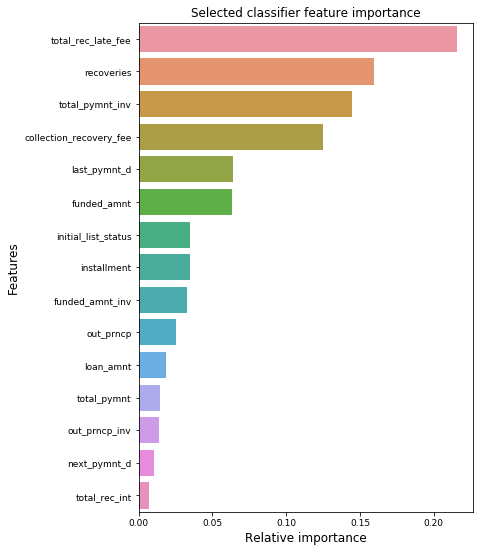

In [45]:
# Display feature importance
plot_feat_imp(small_RF_tuned)

In [46]:
# Select dominant features
features = ['total_rec_late_fee', 'total_pymnt_inv', 'collection_recovery_fee', 'recoveries']

In [47]:
# Show the model performance without each of selected features
for f in features:
    X_sub = X.drop(f, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X_sub, y, test_size = 0.3, random_state = 2606, stratify=y)
    small_RF_tuned = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, random_state=2606)
    small_RF_tuned.fit(X_train, y_train)
    print(f)
    print_score(small_RF_tuned)

total_rec_late_fee
Training accuracy: 0.9966285714285714, Test accuracy: 0.9963333333333333
AUC: 0.9882215200473766
total_pymnt_inv
Training accuracy: 0.9972571428571428, Test accuracy: 0.9962
AUC: 0.9896611015185963
collection_recovery_fee
Training accuracy: 0.9974285714285714, Test accuracy: 0.9962666666666666
AUC: 0.9886582281837714
recoveries
Training accuracy: 0.9974, Test accuracy: 0.9961333333333333
AUC: 0.9900024835066094


Getting rid of any of selected features did not increase our AUC, therefore I will keep all of them in the final model. However, if we would have focused on accuracy metric instead of AUC, dropping one of the first three selected features would result in accuracy increase.

### Final Random Forest Model !

After finding optimum set of parameters and features, it is time to let our Random Forest model shine. I will reload the full dataset now and train the final RF model.

In [49]:
# Reload the full dataset 
X = df.drop(['loan_status'], axis=1)
y = df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2606, stratify=y)

In [50]:
# Train the model and present results
RF_final = RandomForestClassifier(n_estimators=160, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
%time RF_final.fit(X_train, y_train)
print_score(RF_final)

Wall time: 19min 36s
Training accuracy: 0.9979007188106219, Test accuracy: 0.9969009894295566
AUC: 0.9950925564902223


Really impressive AUC of 99.5% !

In [51]:
# Display additional metrics and confusion matrix
report(RF_final)

Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    248568
          1       1.00      0.96      0.98     17646

avg / total       1.00      1.00      1.00    266214

Confusion Matrix:
[[248533     35]
 [   790  16856]]


RF model 35 times falsely predicted that a client will default and 790 times, that a client will not default (expensive mistake!). A huge improvement comparing to Logistic Regression and a lot of saved money. 

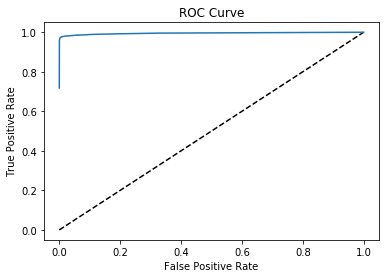

In [52]:
# Display ROC curve
plot_ROC(RF_final)

### XGBoost

XGBoost is sometimes named as 'an ultimate weapon of a data scientist'. It is a powerful algorithm, which very often rises to heights of any predictive model. A vast majority of data competitions are won by XGB experts. It is a versatile and sophisticated technique, which is relatively fast (given its complexity) and produces outstanding results. Random Forest did a really good job in solving our problem, but we may expect even more from XGB!

In [60]:
# Restrict the dataset to 50000 rows 
df_small = sample(df, 50000)
X = df_small.drop(['loan_status'], axis=1)
y = df_small['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2606, stratify=y)

In [61]:
# Train basic XGB model
small_XGB = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5, min_child_weight=1, gamma=0,
             subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=2606)
%time small_XGB.fit(X_train, y_train)
print_score(small_XGB)

Wall time: 6.58 s
Training accuracy: 0.9981428571428571, Test accuracy: 0.9963333333333333
AUC: 0.9938494418011098


Despite small subset of data and not yet tuned hyperparameters, XGB presents quite impressive performance. Similarly to what we have done with Random Forest, let's find optimal hyperparameters using *grid search* and train the final model on the entire data.

In [62]:
# Instantiate parameters for grid search
param_grid1 = {
    'max_depth':[7, 9],
    'min_child_weight':range(1,6,2),
    'gamma':[0.0, 0.1, 0.2],
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

In [63]:
# Check all possible combinations of hyperparameters
CV_XGB = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5, min_child_weight=1, gamma=0,
            subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=2606), 
            param_grid=param_grid1, scoring='roc_auc', cv=2, n_jobs=-1)
%time CV_XGB.fit(X_train, y_train)

CV_XGB.best_params_, CV_XGB.best_score_

Wall time: 13min 54s


({'gamma': 0.1, 'max_depth': 7, 'min_child_weight': 5, 'reg_alpha': 0.005},
 0.994752077015794)

Knowing which hyperparameters to use, it is time for...

## ...The Final Model!

In [64]:
# Reload full data
X = df.drop(['loan_status'], axis=1)
y = df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2606, stratify=y)

In [65]:
# Train the final model
XGB_final = XGBClassifier(learning_rate=0.01, n_estimators=1000, max_depth=7, min_child_weight=5, gamma=0.1, 
                          reg_alpha=0.005, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', 
                          nthread=4, scale_pos_weight=1, seed=2606, n_jobs=-1) 

%time XGB_final.fit(X_train, y_train)
print_score(XGB_final)

Wall time: 27min 45s
Training accuracy: 0.9971215377556688, Test accuracy: 0.9969347968175979
AUC: 0.9960822635009243


In [66]:
# Display additional metrics and confusion matrix
report(XGB_final)

Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    248568
          1       1.00      0.96      0.98     17646

avg / total       1.00      1.00      1.00    266214

Confusion Matrix:
[[248531     37]
 [   779  16867]]


XGB model 37 times falsely predicted that a client will default (small increase comparing to RF) and 779 times, that a client will not default. A small, but valuable improvement!

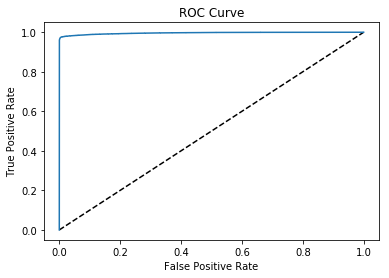

In [67]:
# Display ROC curve
plot_ROC(XGB_final)

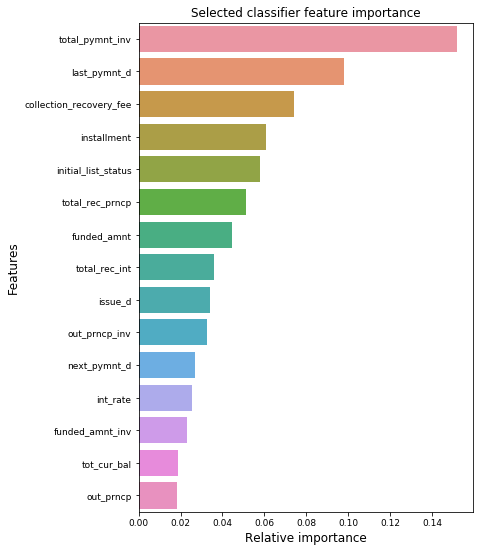

In [68]:
# Display feature importance
plot_feat_imp(XGB_final)

It looks like XGB, conversely to RF, relies on a higher number of features, distributing their importance more smoothly.

## Conclusions

In this notebook, I conducted a study leading to create the highly effective predictive model, explaining thoroughly all taken steps to achieve the impressive result. 

Starting from data pre-processing, throughout different metrics consideration, finishing on machine learning modelling. I compared three different algorithms and proved that even the simple Logistic Regression can deliver decent results in a quick way. Random Forest, after some trials and tweakings, performed significantly better. XGBoost improved the result even further reaching incredible accuracy. 

I believe that the concepts I presented here, like detailed pre-processing, getting a small sample the data, playing with the most important features, or grid search, can, and should be used if someone wants to equip a model with real predictive power. 

Thank you for staying with me to the very end, and I hope you enjoyed this notebook as much as I did!